<a href="https://colab.research.google.com/github/sunil448832/Machine-Learning/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Finetuning The VGG19 model to classify the Food_MNIST data into 10 diffrent classes**

In [23]:
!git clone https://github.com/srohit0/food_mnist.git

fatal: destination path 'food_mnist' already exists and is not an empty directory.


In [24]:

import torch
import numpy as np
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader,Dataset
from matplotlib import pyplot as plt
import torch.nn as nn
from torchvision import models
from PIL import Image
import glob
import time

# to get deterministic behaivior on each run
torch.backends.cudnn.deterministic = True
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
image_dir='/content/food_mnist/images'

imagebyclass_dir=glob.glob(image_dir+'/*')
imagebyclass_dir=[x for x in imagebyclass_dir if x.split("/")[-1] !='food-collage.jpg']
categories=[x.split('/')[-1] for x in imagebyclass_dir] 
label_dict={label:index for index,label in enumerate(categories)}

images,labels=[],[] # To store imgage path and image label
for path in imagebyclass_dir:
  label=path.split('/')[-1]
  for image in glob.glob(path+ '/*'):
    images.append(image)
    labels.append(label_dict[label])

# shuffling the dataset
temp = list(zip(images,labels)) 
np.random.shuffle(temp) 
images_data, images_labels = zip(*temp) 

print(images_data[:10])
print(images_labels[:10])
print(categories)

('/content/food_mnist/images/beignets/2537504.jpg', '/content/food_mnist/images/bread_pudding/1040137.jpg', '/content/food_mnist/images/beef_carpaccio/1931535.jpg', '/content/food_mnist/images/bibimbap/1296263.jpg', '/content/food_mnist/images/beef_carpaccio/1725022.jpg', '/content/food_mnist/images/beignets/1021134.jpg', '/content/food_mnist/images/beef_tartare/215658.jpg', '/content/food_mnist/images/apple_pie/2171324.jpg', '/content/food_mnist/images/beef_tartare/1243361.jpg', '/content/food_mnist/images/apple_pie/1830215.jpg')
(0, 3, 4, 9, 4, 0, 8, 5, 8, 5)
['beignets', 'baklava', 'breakfast_burrito', 'bread_pudding', 'beef_carpaccio', 'apple_pie', 'beet_salad', 'baby_back_ribs', 'beef_tartare', 'bibimbap']


# **Dataset Preparation**

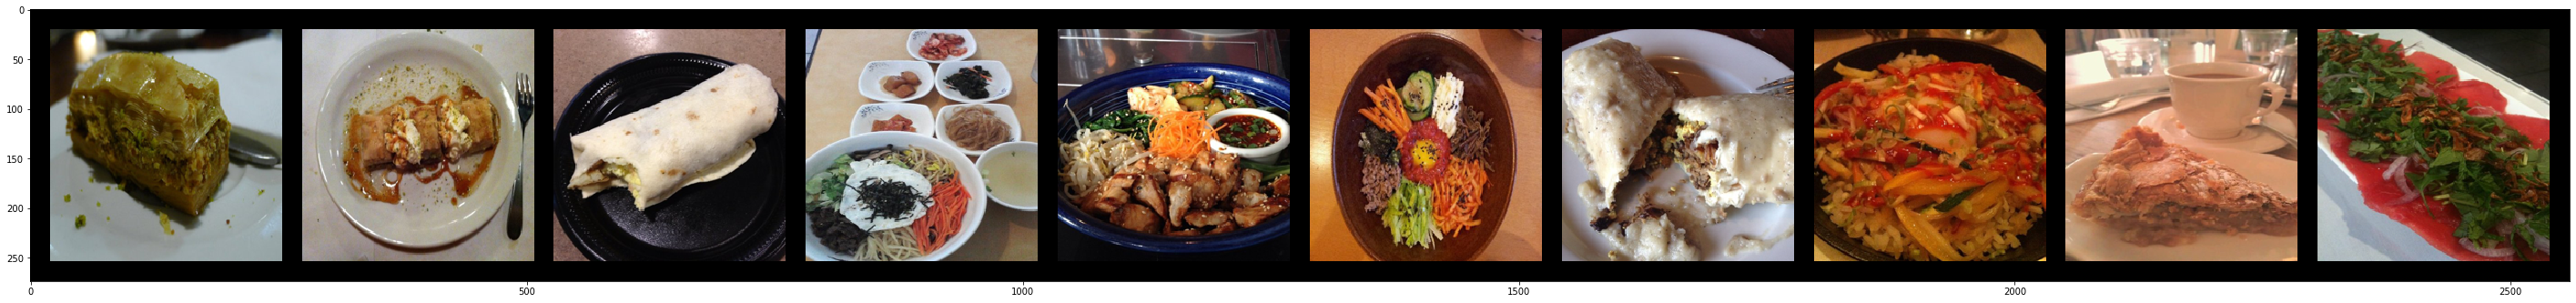

In [26]:

def preprocess(img):
  img = img.convert('RGB')
  img = img.resize((234,234))
  img = torch.Tensor(np.array(img))
  return img.permute(2,0,1).float()/255.0

class MyDataset(Dataset):
  def __init__(self,images,labels):
    self.images=images
    self.labels=labels
    self.transform=transforms.Compose([preprocess])
  
  def __getitem__(self, index):
    img=Image.open(self.images[index])
    label=self.labels[index]
    if self.transform!=None:
      img=self.transform(img)
    return img,label

  def __len__(self):
    return len(self.images)

def show(img):
  plt.figure(figsize=(50,50)) 
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


#training datasize=70%
#validation datasize =20%
#test datasize=10%
train_dataset=MyDataset(images_data[:int(.7*len(images_data))],images_labels[:int(.7*len(images_data))])
val_dataset=MyDataset(images_data[int(.7*len(images_data)):int(.9*len(images_data))],
                      images_labels[int(.7*len(images_data)):int(.9*len(images_data))])
test_dataset=MyDataset(images_data[int(.9*len(images_data)):],images_labels[int(.9*len(images_data)):])


# images from first batch
x,y=next(iter(DataLoader(val_dataset,batch_size=10,shuffle=True)))
grid = torchvision.utils.make_grid(x,nrow=10, padding=20)
show(grid)

# **Finetuning The VGG19 Model by adding custom  10 label classifer**

In [27]:

class VGG19(nn.Module):
  def __init__(self,h,freeze=False):
    super(VGG19,self).__init__()
    self.features=list(models.vgg19_bn(pretrained=True).children())[0]
    self.avg_adap_pool=nn.AdaptiveAvgPool2d(output_size=(7,7))
    self.classifier=nn.Sequential(nn.Linear(512*7*7,h),nn.ReLU(True),nn.Dropout(.1),nn.Linear(h,10))
    if freeze:
      for name,param in self.features.named_parameters():
        param.requires_grad=False
  
  def forward(self,x):
    x=self.features(x)
    x=self.avg_adap_pool(x)
    x=self.classifier(x.view(x.size(0),-1))
    return x


# **Model Training**

-------------------training start ----------------------

at epoch: 0   training_loss: 54.000   validation loss:  9.382  accuracy: 0.80 time: 00:52
at epoch: 1   training_loss: 9.786   validation loss:  8.055  accuracy: 0.83 time: 00:51
at epoch: 2   training_loss: 1.414   validation loss:  8.874  accuracy: 0.84 time: 00:51
at epoch: 3   training_loss: 0.489   validation loss:  7.676  accuracy: 0.86 time: 00:51


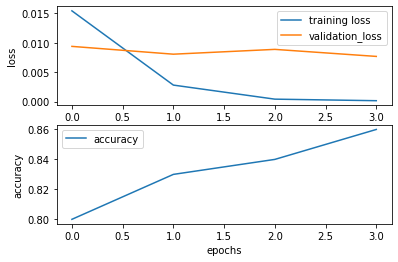

--------------------training finished--------------------


In [29]:

def train_vgg(train_dataset,val_dataset,model,epoch,batch_size):

  optimiser=torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
  criterion=nn.CrossEntropyLoss()
  num_batch_train,num_batch_val=train_dataset.__len__(),val_dataset.__len__()
  train_loss_list,val_loss_list,val_accuracy_list=[],[],[]

  for i in range(epoch):
    train_loss=0
    model.train()
    t1=time.time()
    for sample,label in DataLoader(train_dataset,batch_size=batch_size,shuffle=True):
     
      optimiser.zero_grad()
      sample,label=sample.to(device),label.to(device)
      pred=model(sample)
      loss=criterion(pred,label)
      train_loss+=loss.item()
      loss.backward()
      optimiser.step()
    train_loss_list.append(train_loss/num_batch_train)
   

    val_loss=0
    val_pred_list,val_label_list=[],[]
    with torch.no_grad():
      model.eval()
      for sample,label in DataLoader(val_dataset,batch_size=batch_size,shuffle=True):
        sample,label=sample.to(device),label.to(device)
        pred=model(sample)
        loss=criterion(pred,label)
        val_loss+=loss.item()
        val_pred_list.extend(torch.argmax(pred,axis=1).cpu().numpy())
        val_label_list.extend(label.cpu().numpy())

    val_loss_list.append(val_loss/num_batch_val)
    
    accuracy=(np.array(val_label_list)==np.array(val_pred_list)).sum()/(len(val_label_list))
    val_accuracy_list.append(accuracy.round(2))
    
    print("at epoch: %d   training_loss: %.3f   validation loss:  %.3f  accuracy: %.2f time: 00:%d"
            %(i,train_loss,val_loss,accuracy,time.time()-t1))
    
  plt.subplot(2,1,1) 
  plt.plot(list(range(epoch)),train_loss_list,label='training loss')
  plt.plot(list(range(epoch)),val_loss_list,label='validation_loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.subplot(2,1,2)
  plt.plot(list(range(epoch)),val_accuracy_list,label='accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()
  

epoch=4
batch_size=64
training=True

if training:
  print('-------------------training start ----------------------\n')
  model=VGG19(1024).to(device)
  train_vgg(train_dataset,val_dataset,model,epoch,batch_size)
  print("--------------------training finished--------------------")
    

# **Training using FastAPI**

In [ ]:
!pip install -qqq wandb
!pip install -qqqU fastai
from fastai.vision.all import *
from fastai.data.core import DataLoaders

#spiliter to split models used to freeze any section
splitter=lambda model:[params(model.features),params(model.avg_adap_pool),params(model.classifier)]

# FastAI dataloader
dls = DataLoaders.from_dsets(train_dataset, test_dataset).to(device)


learn = Learner(dls,VGG19(1024).to(device),
                  loss_func=CrossEntropyLossFlat(),
                  metrics=accuracy,
                  splitter=splitter
                  )


SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=0.0002290867705596611)

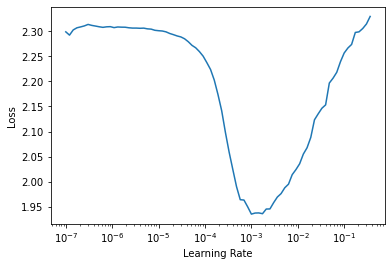

In [ ]:
learn.freeze_to(0) # freezing first layer
learn.lr_find() # finding optimal learning rate

In [ ]:
learn.fit_one_cycle(4, 1e-3)               #training for 4 epochs with lr=1e-3
learn.unfreeze()                           # now unfreeze the freezed layer
learn.fit_one_cycle(3, slice(1e-4,1e-3))   # now train whole model

epoch,train_loss,valid_loss,accuracy,time
0,1.302396,10.257442,0.206000,00:41
1,1.110105,1.385387,0.576000,00:41
2,0.755010,0.783269,0.732000,00:41
3,0.375493,0.519304,0.808000,00:41


epoch,train_loss,valid_loss,accuracy,time
0,0.195097,0.794117,0.808000,00:41
1,0.149868,0.694391,0.826000,00:41
2,0.072070,0.664233,0.850000,00:41
